#  final version

LSTM that can produce music training with a midi dataset
[credits](https://www.kdnuggets.com/2020/07/pytorch-lstm-text-generation-tutorial.html)

In [6]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
#from tqdm.notebook import tqdm, trange
from tqdm.auto import tqdm, trange
import numpy as np
import matplotlib.pyplot as plt
import pickle
from music21 import *
from os import listdir
from collections import Counter
import pyperclip
DIR = '../midiFiles'

## caricatore e lettore di dati, direttamente in un dataset pytorch

In [21]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
            self,
            sequence_length,
            file_limit,
            reload_from_save=False
    ):
        if reload_from_save:
            self.reload_from_save()
            return

        self.sequence_length = sequence_length
        self.notes = self.load_notes(file_limit)
        self.uniq_notes = self.get_uniq_notes()

        self.index_to_note = {index: note  for index, note in enumerate(self.uniq_notes)}
        self.note_to_index = {note: index for index, note in enumerate(self.uniq_notes)}

        self.notes_indexes = np.array([self.note_to_index[w] for w in self.notes], dtype='int64')

    def load_notes(self, file_limit):
        out = []
        if file_limit is None:
            file_limit = len(listdir(DIR))

        for file in tqdm(listdir(DIR), total=file_limit):
            if not "mid" in file:
                continue

            if file_limit <= 0:
                break
            else:
                file_limit -= 1

            midifile = converter.parse(DIR + '/' + file)

            #ho solo il piano
            notes_to_parse = midifile.flat.notes

            for element in notes_to_parse:

                if isinstance(element, note.Note):
                    out.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    out.append('.'.join(str(n) for n in element.normalOrder))
        return out

    def get_uniq_notes(self):
        note_counts = Counter(self.notes)
        return sorted(note_counts, key=note_counts.get, reverse=True)

    def save(self):
        path_pre = 'saves/'
        to_save = [self.sequence_length, self.notes, self.uniq_notes, self.index_to_note, self.note_to_index, self.notes_indexes]
        paths = ['length', 'notes', 'uniques', 'index_dict', 'note_dict', 'indexes']

        for var, path in zip(to_save, paths):
            with open(path_pre + path + '.pickle', 'wb') as filepath:
                pickle.dump(var, filepath)


    def reload_from_save(self):
        path_pre = 'saves/'
        to_save = ['sequence_length', 'notes', 'uniq_notes', 'index_to_note', 'note_to_index', 'notes_indexes']
        paths = ['length', 'notes', 'uniques', 'index_dict', 'note_dict', 'indexes']

        for var, path in zip(to_save, paths):
            with open(path_pre + path + '.pickle', 'rb') as filepath:
                value = pickle.load(filepath)
                setattr(self, var, value)

    def __len__(self):
        return len(self.notes_indexes) - self.sequence_length

    def __getitem__(self, index):
        return (
            torch.tensor(self.notes_indexes[index:index+self.sequence_length]),
            torch.tensor(self.notes_indexes[index+1:index+self.sequence_length+1]),
        )


rete neurale LSTM

In [10]:
class LSTMNetwork(nn.Module):
    def __init__(self, dataset):
        super(LSTMNetwork, self).__init__()
        self.lstm_size = 128
        self.embedding_dim = 128
        self.num_layers = 3

        n_vocab = len(dataset.uniq_notes)
        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )
        self.lstm = nn.LSTM(
            input_size=self.lstm_size,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)

    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state

    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [11]:
def train(dataset, model, device, batch_size, sequence_length, max_epochs):
    losses = []

    model.train()

    dataloader = DataLoader(dataset, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in trange(max_epochs, leave=True):
        state_h, state_c = model.init_state(sequence_length)

        for batch, (x, y) in tqdm(enumerate(dataloader), leave=False, position=1, total=len(dataloader)):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            y_pred, (state_h, state_c) = model(x, (state_h, state_c))
            loss = criterion(y_pred.transpose(1, 2), y)

            state_h = state_h.detach()
            state_c = state_c.detach()

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if batch % 100 == 0:
                pass
                #print({ '###  epoch': epoch+1, 'batch': batch, 'loss': loss.item() })

    return losses

funzione per generare una serie di note data una serie di partenza

In [11]:
def predict(dataset, model, start, next_notes=100):
    model.eval()

    notes = start.split(' ')
    state_h, state_c = model.init_state(len(notes))

    for i in range(0, next_notes):
        x = torch.tensor([[dataset.note_to_index[w] for w in notes[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))

        last_note_logits = y_pred[0][-1]
        p = torch.nn.Softmax()(last_note_logits).detach().numpy()
        note_index = np.random.choice(len(last_note_logits), p=p)
        notes.append(dataset.index_to_note[note_index])

    return notes

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [22]:
sequence_length = 32
reload = True   #mettere a true per leggere da un file
dataset = Dataset(sequence_length= sequence_length, file_limit=100, reload_from_save=reload)
if not reload:
    # save to disk
    dataset.save()

In [18]:
model = LSTMNetwork(dataset).to(device)
print(model)

train_losses = train(dataset, model, device, batch_size=256, max_epochs=10, sequence_length= sequence_length)

NameError: name 'dataset' is not defined

### Grafico delle loss durante il training

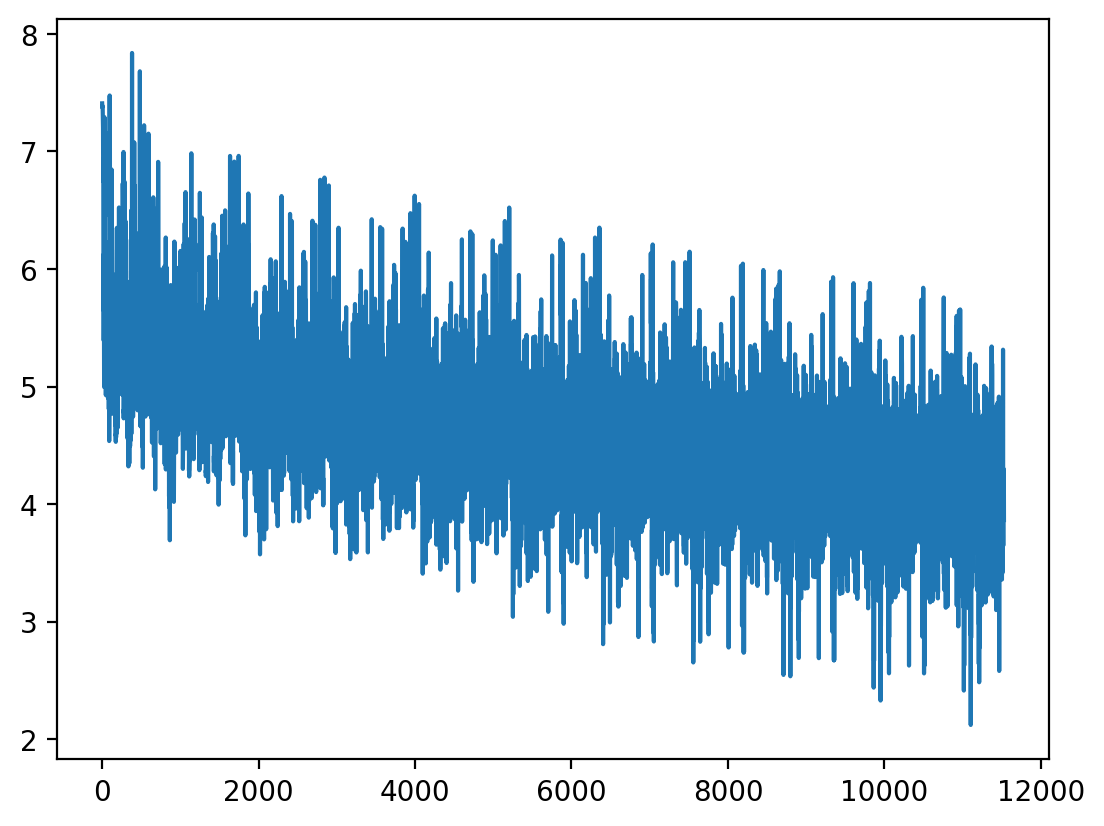

In [16]:
plt.plot(train_losses)
plt.show()

funzioni comode per salvare e caricare il modello

In [8]:
def save_model(model, number=0):
    with open('saves/modello' + str(number) + '.pickle', 'wb') as filepath:
        pickle.dump(model, filepath)

def load_model(number=0):
    with open('saves/modello' + str(number) + '.pickle', 'rb') as filepath:
        return pickle.load(filepath)

In [18]:
save_model(model, 3)

In [12]:
model = load_model(3)

In [13]:
def create_midi(prediction_output, strumento):
    if strumento is None:
        strumento = instrument.Piano()

    offset = 0
    output_notes = []

    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = strumento
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = strumento
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    return midi_stream

In [23]:
music = predict(dataset, model, start='C5 G4 E4 C3 C2 A4 D4 C3 C2 G4 C4 C3 C2 E5 F4 C3')
generated_stream = create_midi(music, instrument.Banjo())#non sono capace di cambiare lo strumento
path = generated_stream.write('midi', fp='./saves/midi/sette.midi')
print(path)

C:\Users\samuele.facenda\AppData\Local\Temp\ipykernel_3420\2305584100.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  p = torch.nn.Softmax()(last_note_logits).detach().numpy()


./saves/midi/sette.midi


prende le prime tot note da un pezzo dato, volendo copia nella clipboard

In [14]:
def print_notes(file_number, notes, copy_to_clipboard=False):
    midifile = converter.parse('../midiFiles/track' + str(file_number) + '.midi')

    #ho solo il piano
    notes_to_parse = midifile.flat.notes
    out=[]
    for element in notes_to_parse:

        if notes <= 0:
            break
        else:
            notes -= 1

        if isinstance(element, note.Note):
            out.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            out.append('.'.join(str(n) for n in element.normalOrder))
    out = ' '.join(out)
    print(out)
    if copy_to_clipboard:
        pyperclip.copy(out)

    return out

In [15]:
print_notes(50, 16, copy_to_clipboard=True)

C5 G4 E4 C3 C2 A4 D4 C3 C2 G4 C4 C3 C2 E5 F4 C3


'C5 G4 E4 C3 C2 A4 D4 C3 C2 G4 C4 C3 C2 E5 F4 C3'